In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import os

sns.set(style="whitegrid")

In [4]:
# Load the dataset
file_path = "D:/Hunar Intern/food_coded.csv"
df = pd.read_csv(file_path)
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (125, 61)

First 5 rows:
     GPA  Gender  breakfast  calories_chicken  calories_day  calories_scone  \
0    2.4       2          1               430           NaN           315.0   
1  3.654       1          1               610           3.0           420.0   
2    3.3       1          1               720           4.0           420.0   
3    3.2       1          1               430           3.0           420.0   
4    3.5       1          1               720           2.0           420.0   

   coffee                      comfort_food        comfort_food_reasons  \
0       1                              none       we dont have comfort    
1       2       chocolate, chips, ice cream        Stress, bored, anger   
2       2   frozen yogurt, pizza, fast food             stress, sadness   
3       2  Pizza, Mac and cheese, ice cream                     Boredom   
4       2      Ice cream, chocolate, chips   Stress, boredom, cravings    

   comfort_food_reasons_coded  ...

In [6]:
# Check for missing values
print("\nMissing values per column:")
missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_data = pd.concat([missing_values, missing_percent], axis=1)
missing_data.columns = ['Missing Values', 'Percentage']
print(missing_data[missing_data['Missing Values'] > 0])


Missing values per column:
                            Missing Values  Percentage
GPA                                      2         1.6
calories_day                            19        15.2
calories_scone                           1         0.8
comfort_food                             1         0.8
comfort_food_reasons                     2         1.6
comfort_food_reasons_coded              19        15.2
cook                                     3         2.4
cuisine                                 17        13.6
diet_current                             1         0.8
drink                                    2         1.6
eating_changes                           3         2.4
employment                               9         7.2
exercise                                13        10.4
father_education                         1         0.8
father_profession                        3         2.4
fav_cuisine                              2         1.6
fav_food                             

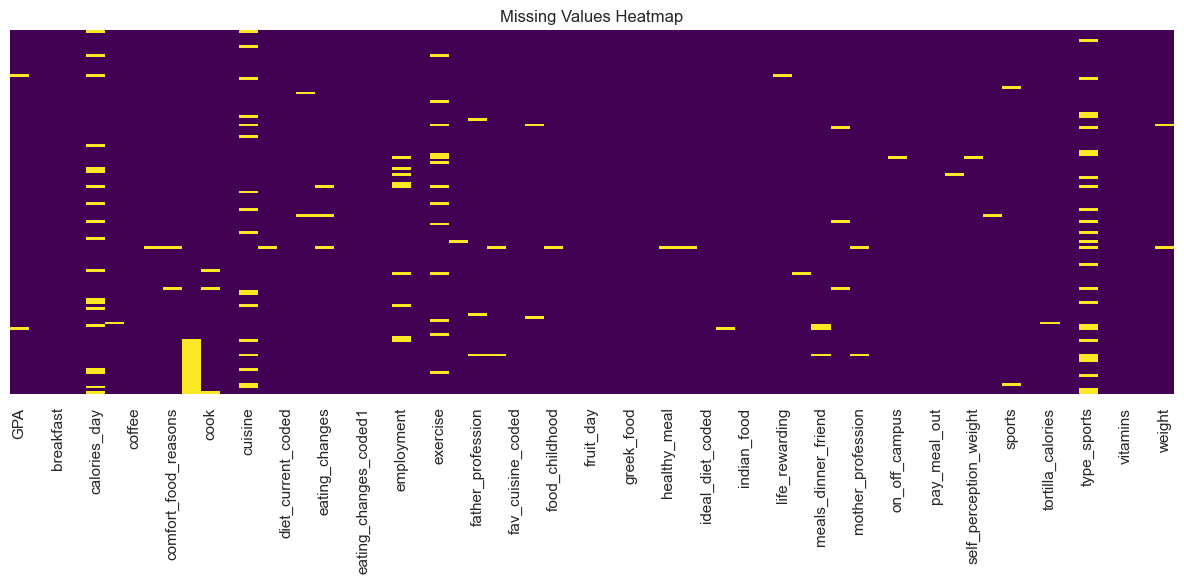

In [8]:
# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()

In [10]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")


Number of duplicate rows: 0


In [12]:
# Make a copy of the original dataframe for comparison
df_original = df.copy()

In [14]:
# Identify numerical columns correctly - only include actual numeric columns
# This is the key fix - ensure we're only working with actual numeric columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(f"Numeric columns: {list(numerical_cols)}")

Numeric columns: ['Gender', 'breakfast', 'calories_chicken', 'calories_day', 'calories_scone', 'coffee', 'comfort_food_reasons_coded', 'cook', 'comfort_food_reasons_coded.1', 'cuisine', 'diet_current_coded', 'drink', 'eating_changes_coded', 'eating_changes_coded1', 'eating_out', 'employment', 'ethnic_food', 'exercise', 'father_education', 'fav_cuisine_coded', 'fav_food', 'fries', 'fruit_day', 'grade_level', 'greek_food', 'healthy_feeling', 'ideal_diet_coded', 'income', 'indian_food', 'italian_food', 'life_rewarding', 'marital_status', 'mother_education', 'nutritional_check', 'on_off_campus', 'parents_cook', 'pay_meal_out', 'persian_food', 'self_perception_weight', 'soup', 'sports', 'thai_food', 'tortilla_calories', 'turkey_calories', 'veggies_day', 'vitamins', 'waffle_calories']


In [16]:
# Check for correlation only if we have enough numerical columns
if len(numerical_cols) > 1:  # Need at least 2 columns for correlation
    correlation = df[numerical_cols].corr().abs()
    upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
    potential_duplicates = [column for column in upper.columns if any(upper[column] > 0.95)] 
    print(f"\nPotential duplicate columns (correlation > 0.95): {potential_duplicates}")
    if potential_duplicates:
        print("\nHighly correlated column pairs:")
        for column in potential_duplicates:
            correlated_columns = upper[column][upper[column] > 0.95].index.tolist()
            for corr_col in correlated_columns:
                print(f"- {column} and {corr_col}: {upper[column][corr_col]:.4f}")
else:
    print("Not enough numeric columns to calculate correlation.")


Potential duplicate columns (correlation > 0.95): ['comfort_food_reasons_coded.1']

Highly correlated column pairs:
- comfort_food_reasons_coded.1 and comfort_food_reasons_coded: 0.9892


In [18]:
# Handle missing values in numerical columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[f'{col}_mean_imputed'] = df[col].fillna(df[col].mean())
        df[f'{col}_median_imputed'] = df[col].fillna(df[col].median())
        df[col] = df[col].fillna(df[col].median())

In [20]:
# Handle missing values in categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0]
        df[col] = df[col].fillna(mode_value)

In [22]:
# Remove duplicate rows
df_no_duplicates = df.drop_duplicates()
print(f"\nRows removed after dropping duplicates: {len(df) - len(df_no_duplicates)}")
df = df_no_duplicates


Rows removed after dropping duplicates: 0


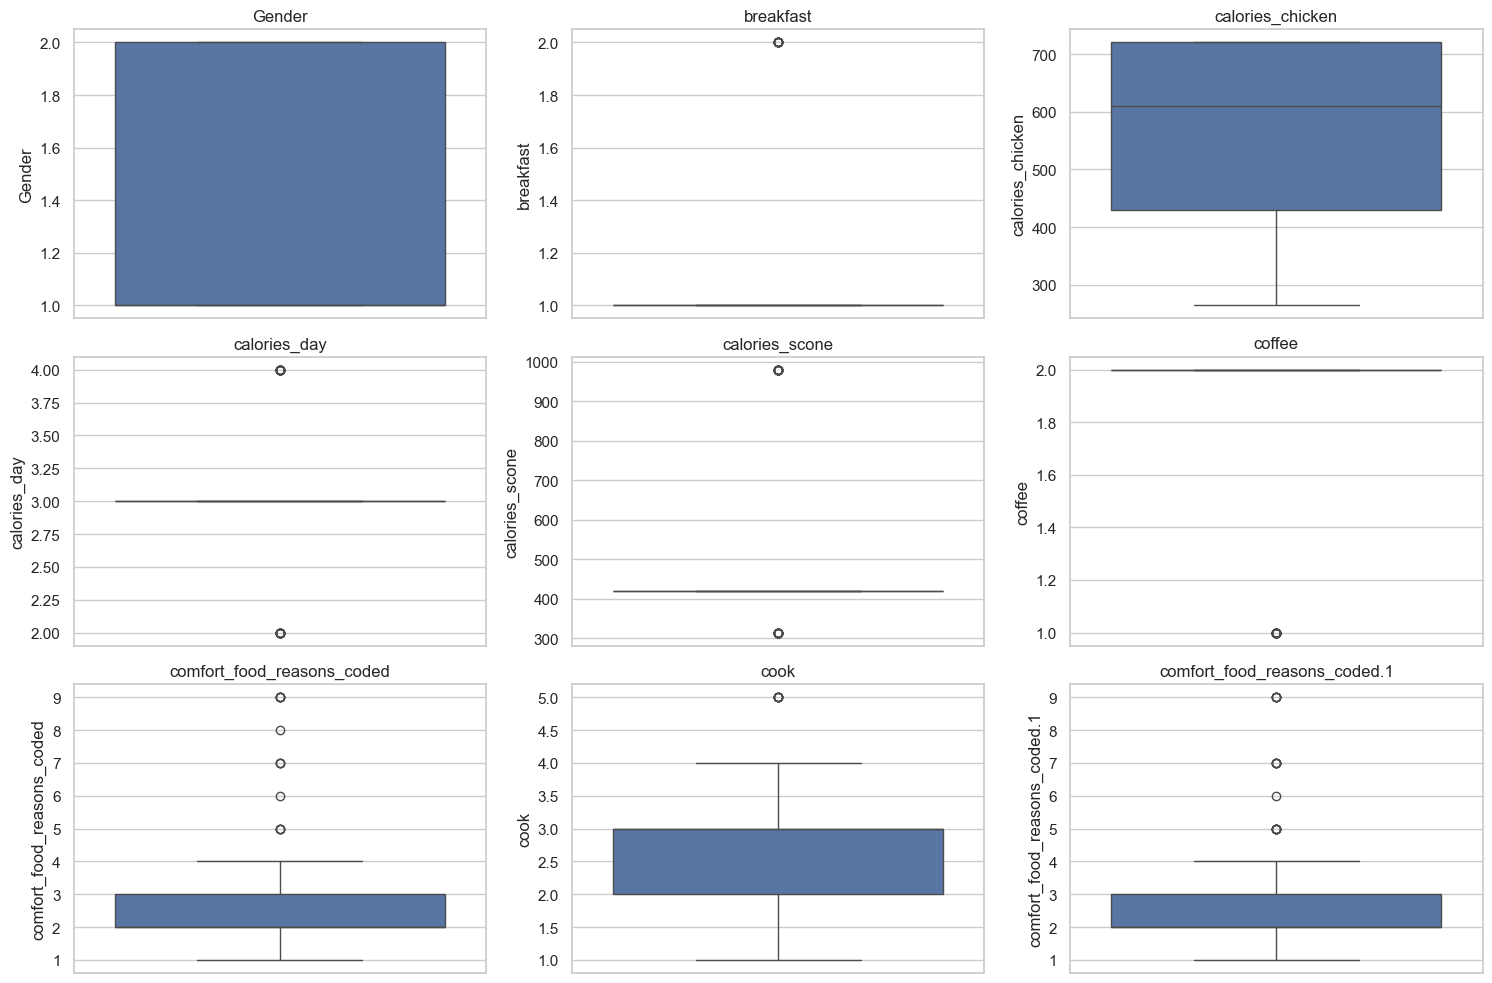

In [24]:
# Check for outliers in numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols[:min(len(numerical_cols), 9)]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [25]:
# Final check for missing values
final_missing = df.isnull().sum().sum()
print(f"\nRemaining missing values after cleaning: {final_missing}")


Remaining missing values after cleaning: 0


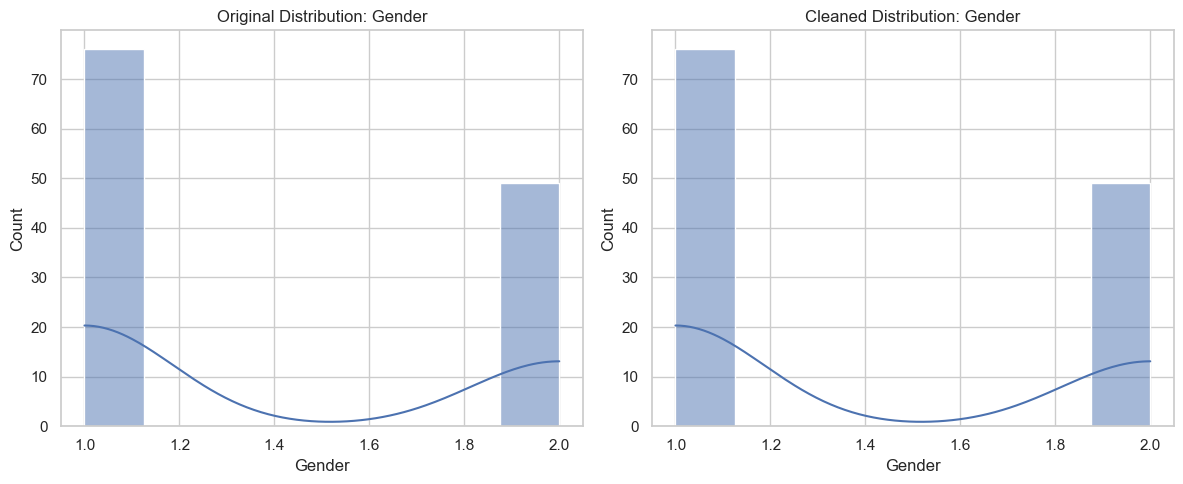

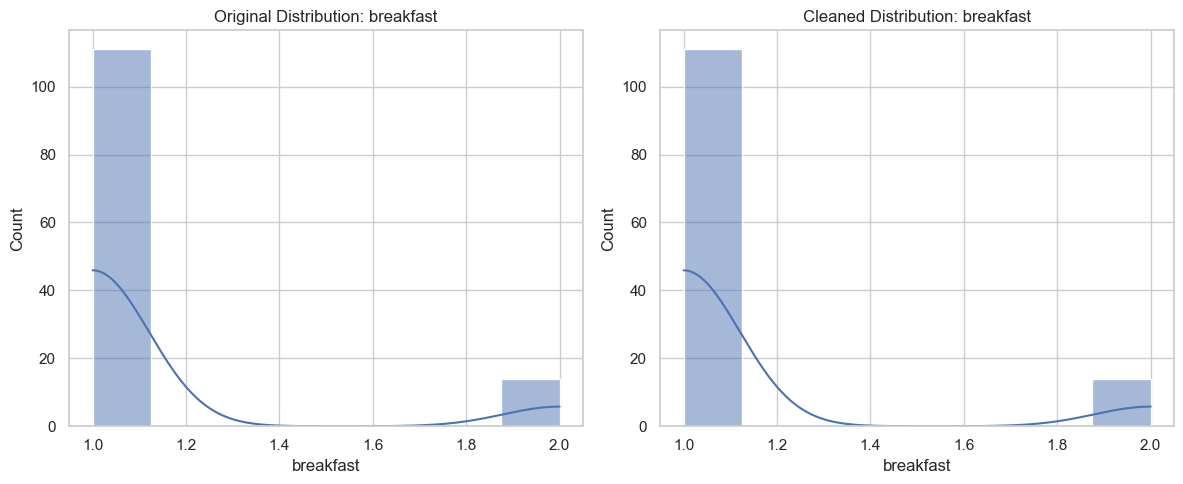

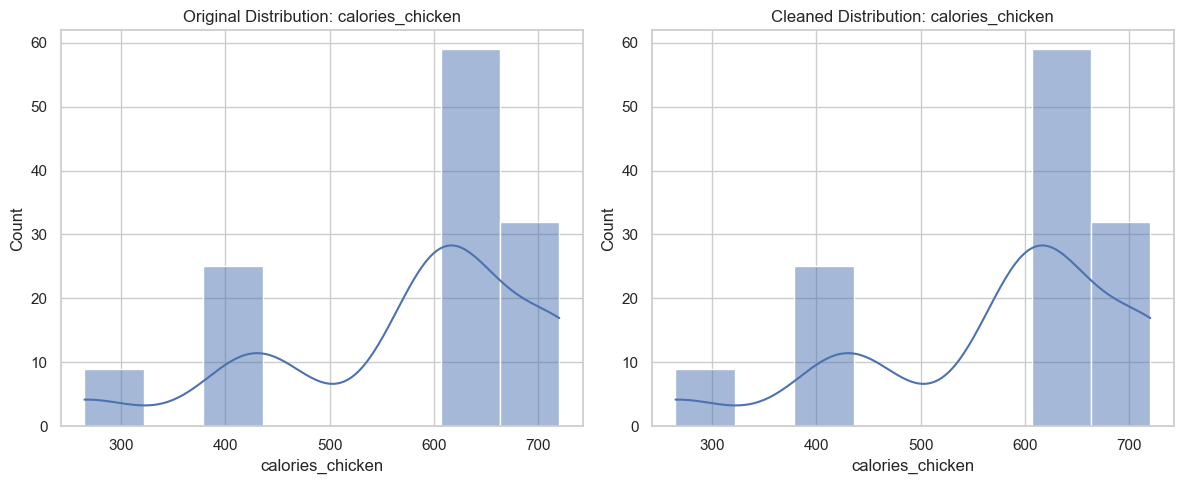

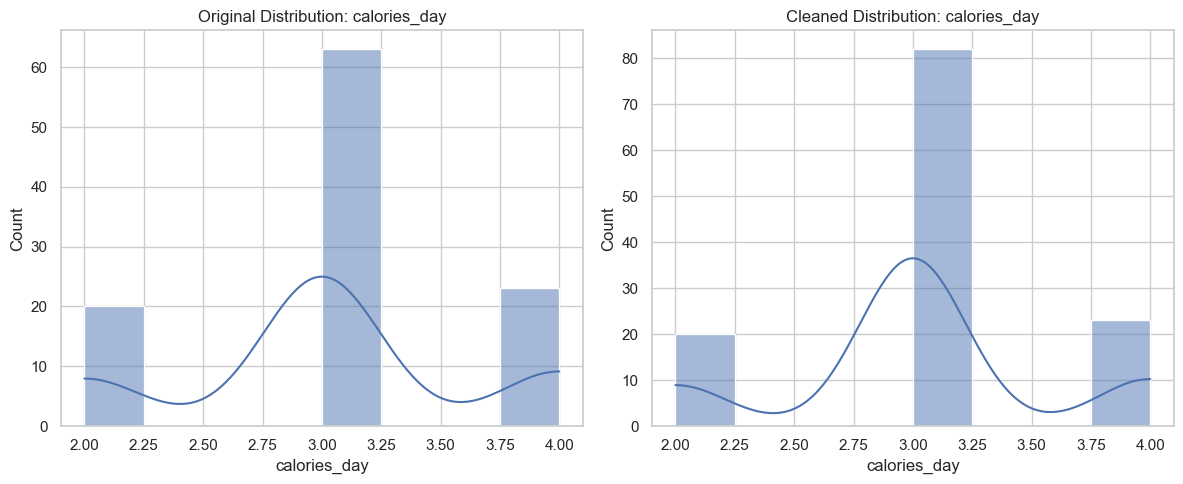

In [28]:
# Compare distributions before and after cleaning
for col in numerical_cols[:min(len(numerical_cols), 4)]:
    plt.figure(figsize=(12, 5))    
    plt.subplot(1, 2, 1)
    sns.histplot(df_original[col].dropna(), kde=True)
    plt.title(f'Original Distribution: {col}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(df[col], kde=True)
    plt.title(f'Cleaned Distribution: {col}')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Save the cleaned dataset
df.to_csv('cleaned_dataset.csv', index=False)
print("\nCleaned dataset saved as 'cleaned_dataset.csv'")

In [ ]:
# Print summary of cleaning operations
print("\n=== Data Cleaning Summary ===")
print(f"Original dataset shape: {df_original.shape}")
print(f"Cleaned dataset shape: {df.shape}")
print(f"Missing values filled: {df_original.isnull().sum().sum()}")
print(f"Duplicate rows removed: {len(df_original) - len(df)}")